In [2]:
%reload_ext autoreload
%autoreload 2

# ! pip install future installing packages works from here, not always from cmd line
# ! pip install opencv-python
# ! pip install holoviews
# ! pip install -U scikit-image
# ! pip install tiffile
#caiman downloaded with conda and saved inside anaconda3 envs is not working. Keeps saying that there is no module named 'caiman'. appending C:\Users\kmm171\CaImAn to sys.path solved the problem.

import sys
sys.path.append(r'C:\Users\kmm171\ImageAnalysis\caImageAnalysis')
import main.main_eva as main_eva

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from natsort import index_natsorted, natsorted
from scipy.ndimage import uniform_filter
from scipy.signal import savgol_filter
import scipy
from math import ceil
import plotly.express as px
import warnings
from scipy.stats import linregress
from tqdm import tqdm
from tifffile import imwrite, imread
import seaborn as sns
import numpy as np
import pandas as pd
import os
from utilities.pathutils import pathcrawler

In [5]:
datapath = r'C:\Users\kmm171\Desktop\Data\gut_tectum\20230820_7dpf\fish2\38h_1cmback_huch2bgcamp6s_7dpf_unfed_12hrs_mono_R_20230820'

dory = main_eva.Fish(datapath, stimkey="output")
dory.stimulus_df_condensed

,stim_name,static_time,motion_time,static_frame,motion_frame
0,4,16:53:12.087971,16:53:17.103962,43,58
1,33,16:53:32.104042,16:53:37.104479,103,118
2,6,16:53:52.104399,16:53:57.104790,162,177
3,21,16:54:12.105039,16:54:17.104733,221,236
4,2,16:54:32.104679,16:54:37.105076,281,296
5,3,16:54:52.105296,16:54:57.104740,340,355
6,1,16:55:12.105204,16:55:17.105328,400,414
7,4,16:55:32.105108,16:55:37.105146,459,474
8,33,16:55:52.105953,16:55:57.105544,518,533
9,6,16:56:12.105858,16:56:17.105895,578,592


In [4]:
if not os.path.exists(dory.dataPaths['image'].parents[0].joinpath('original_image')):
    ## BEGIN MOVEMENT CORRECTION

    imgpath = dory.dataPaths['image']
    movement_image = dory.movement_correction(imgpath)

    newdir = imgpath.parents[0].joinpath("original_image")

    if not os.path.exists(newdir):
        os.mkdir(newdir)

    new_path = newdir.parents[0].joinpath("movement_corr_img.tif")
    '''
    og_img_path = newdir.joinpath("image.tif")
    if os.path.exists(og_img_path):
        os.remove(og_img_path)
    shutil.move(imgpath, og_img_path)
    '''
    imwrite(new_path, movement_image)
    '''
    prev_path = Path(dory.dataPaths["image"].parents[0]).joinpath("image.tif")
    try:
        if os.path.exists(prev_path) and os.path.exists(new_path):
            os.remove(prev_path)
    except:
        imwrite(new_path, movement_image) ## i rebooted the kernel here because it was angry that it couldnt move the thing while holding the thing, this works better from external script
    '''
    ## END MOVEMENT CORRECTION
else:
    print('dory found it')


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [6]:
from suite2p import run_s2p, default_ops

## BEGIN SUITE2P
dory.parsePaths()

imagepath = dory.dataPaths['image']

frametimepath = dory.dataPaths['frametimes']
frametimes = dory.raw_text_frametimes_to_df(frametimepath)
imageHz = dory.hzReturner(frametimes)
print(f'imageHz: {imageHz}')

s2p_ops = {
    "data_path": [imagepath.parents[0].as_posix()],
    "save_path0": imagepath.parents[0].as_posix(),
    "tau": 1.5,
    "preclassify": 0.15,
    "allow_overlap": True,
    "block_size": [12,12],
    "fs": imageHz,
}

ops = default_ops()
db = {}
for item in s2p_ops:
    ops[item] = s2p_ops[item]

output_ops = run_s2p(ops=ops, db=db)

## END SUITE2P

imageHz: 2.710843373493976
{}
tif
** Found 1 tifs - converting to binary **
time 4.66 sec. Wrote 1716 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default C:\Users\kmm171\.suite2p\classifiers\classifier_user.npy
----------- REGISTRATION
Reference frame, 9.47 sec.
Registered 500/1716 in 97.27s
Registered 1000/1716 in 193.03s
Registered 1500/1716 in 289.22s
Registered 1716/1716 in 331.63s


C:\Users\kmm171\AppData\Roaming\Python\Python39\site-packages\suite2p\registration\register.py:45: RuntimeWarning: invalid value encountered in divide
  dxy = dxy / dxy.mean()


----------- Total 344.17 sec
Registration metrics, 52.50 sec.
----------- ROI DETECTION
Binning movie in chunks of length 04
Binned movie of size [429,346,346] created in 0.84 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 5.00 
0 ROIs, score=112.67
1000 ROIs, score=13.38
2000 ROIs, score=10.67
3000 ROIs, score=9.24
4000 ROIs, score=8.18
Detected 5000 ROIs, 21.37 sec
['npix_norm', 'compact']
Preclassify threshold 0.15, 3985 ROIs removed
After removing overlaps, 869 ROIs remain
----------- Total 30.45 sec.
----------- EXTRACTION
Masks created, 0.79 sec.
Extracted fluorescence from 869 ROIs in 1716 frames, 2.36 sec.
----------- Total 3.32 sec.
----------- CLASSIFICATION
['npix_norm', 'compact', 'skew']
----------- SPIKE DECONVOLUTION
----------- Total 0.10 sec.
Plane 0 processed in 430.76 sec (can open in GUI).
total = 435.55 sec.
TOTAL RUNTIME 435.55 sec


#### creating a dictionary where each stimulus (key) is assigned a color (value)

In [4]:
color_dict = {}
for n, val in enumerate(dory.stimulus_df_condensed.stim_name.unique()):
    color_dict[val] = sns.color_palette("bright",4)[n]
for k, v in color_dict.items():
    old_colors = list(v)
    new_alpha = [0.75]

    color_dict[k] = old_colors + new_alpha
color_dict

{'4': [0.00784313725490196, 0.24313725490196078, 1.0, 0.75],
 '1': [1.0, 0.48627450980392156, 0.0, 0.75],
 '2': [0.10196078431372549, 0.788235294117647, 0.2196078431372549, 0.75],
 '8': [0.9098039215686274, 0.0, 0.043137254901960784, 0.75]}

In [25]:
color_dict = {'1': [0.00784313725490196, 0.24313725490196078, 1.0, 0.75],
              '2': [0.00784313725490196, 0.24313725490196078, 1.0, 0.75],
              '3': [0.00784313725490196, 0.24313725490196078, 1.0, 0.75],
              '17': [0.9098039215686274, 0.0, 0.043137254901960784, 0.75]}

In [5]:
dory.parsePaths()

basepath = dory.dataPaths['image'].parents[0].joinpath('suite2p')
dory.dataPaths["suite2p"] = {
        "iscell": basepath.joinpath(
            "plane0/iscell.npy"
        ),
        "stats": basepath.joinpath(
            "plane0/stat.npy"
        ),
        "ops": basepath.joinpath(
            "plane0/ops.npy"
        ),
        "f_cells": basepath.joinpath(
            "plane0/F.npy"
        ),
        "f_neuropil": basepath.joinpath(
            "plane0/Fneu.npy"
        ),
        "spikes": basepath.joinpath(
            "plane0/spks.npy"
        ),
        "data": basepath.joinpath(
            "plane0/data.bin"
        ),
    }

In [6]:
offset=6

ops, iscell, stats, f_cells = dory.load_suite2p(dory.dataPaths['suite2p'])
f_cells = dory.norm_fdff(f_cells)

neuron_responses = {}
neuron_stds = {}

for stimulus in dory.stimulus_df_condensed.stim_name.unique():
    stimmy_df = dory.stimulus_df_condensed[
        dory.stimulus_df_condensed.stim_name == stimulus
        ]

    starts = stimmy_df['static_frame'].values

    allArrs = []
    for start_val in starts:
        stimArr = f_cells[:, start_val + 2 : start_val + 2 + offset]
        bgArr = f_cells[:, start_val - offset : start_val - 1]
        diffArr = np.nanmean(stimArr, axis=1) - np.nanmean(bgArr, axis=1)
        allArrs.append(diffArr)
    meanVals = np.nanmean(allArrs, axis=0)
    stdVals = np.nanstd(allArrs, axis=0)

    neuron_responses[stimulus] = meanVals
    neuron_stds[stimulus] = stdVals

responses = pd.DataFrame(neuron_responses)
errors = pd.DataFrame(neuron_stds)
bool_df = responses >= errors
responders = bool_df[bool_df.sum(axis=1) > 0]
f_cells = pd.DataFrame(f_cells)

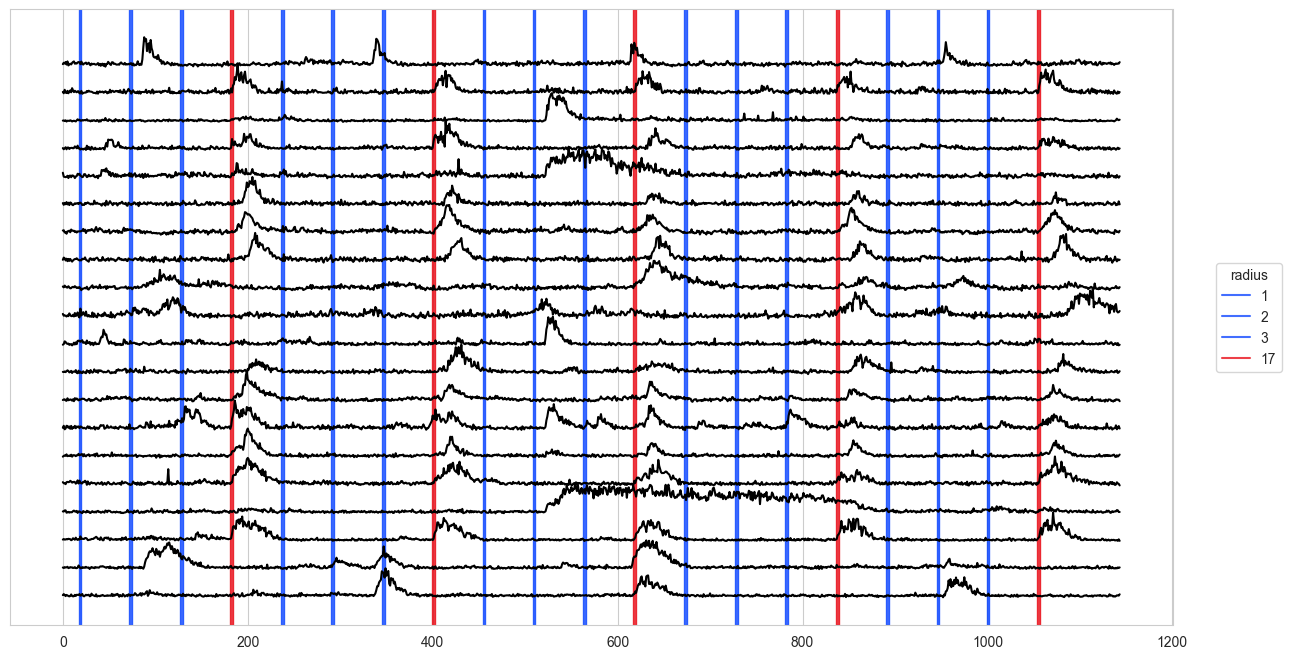

In [26]:
static_frames = dory.stimulus_df_condensed['static_frame']
motion_frames = dory.stimulus_df_condensed['motion_frame']

plt.figure(figsize=(15,8))

stimmies = dory.stimulus_df_condensed['stim_name']

for z in range(20): #responders.index.tolist()[0:20]: #
    plt.plot(np.arange(len(f_cells.iloc[z])), f_cells.iloc[z] + z, color="black")

for frame, stimmy in zip(static_frames, stimmies):
    if stimmy in color_dict.keys():
        plt.axvspan(frame + 3, frame, color=color_dict[stimmy]) #+ 0.20
'''
for frame, stimmy in zip(motion_frames, stimmies):
    if stimmy in color_dict.keys():
        plt.axvspan(frame + 3 , frame, color=color_dict[stimmy]) #+ 0.20
'''

#plt.xlim(0, 380)
legend_lines = [Line2D([0], [0], color=clr) for clr in color_dict.values()]
legend_labels = [str(label) for label in color_dict.keys()]

plt.legend(legend_lines, legend_labels, title="radius", loc='center right', bbox_to_anchor=(1.1,0.5))
plt.yticks([])
plt.show()


In [27]:
cell_img = np.zeros((ops["Ly"], ops["Lx"], 4), 'float64')

for row in range(len(responders)):
    cell = responders.iloc[row]

    nrn_color = [0,0,0,0]

    for stim in color_dict.keys():
        if cell[stim]:
            nrn_color = [nrn_color[i] + color_dict[stim][i] for i in range(len(nrn_color))]
        else:
            pass

    nrn_color = np.clip(nrn_color, a_min=0, a_max=1)
    ypix = stats[cell.name]['ypix']
    xpix = stats[cell.name]['xpix']

    for n, c in enumerate(nrn_color):
        cell_img[ypix, xpix, n] = c


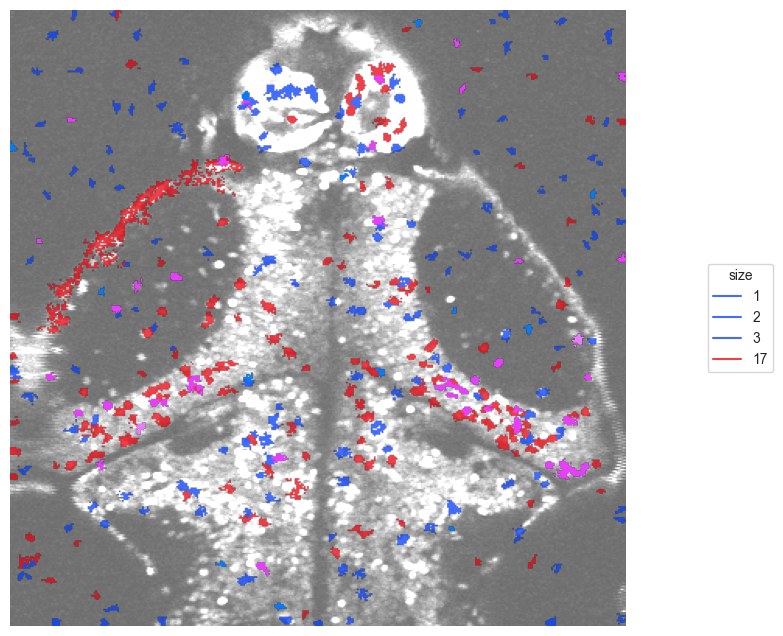

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.imshow(ops['refImg'], cmap='gray', vmin=0, vmax=255)
ax.imshow(cell_img)

ax.axis('off')

legend_lines = [Line2D([0], [0], color=v) for v in color_dict.values()]
legend_labels = [str(label) for label in color_dict.keys()]

plt.legend(legend_lines, legend_labels, loc='right', bbox_to_anchor=[1.25, 0.5], title='size')
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ops["refImg"], cmap=mpl.cm.gray, vmax=250)
plt.axis('off')
plt.show()

#plot individual brainmaps
cells_to_plot = [int(idx) for idx in responders.index]

for cell in cells_to_plot:
    cell_img = np.zeros((ops["Ly"], ops["Lx"]))

    if isinstance(cell, int):
        cells = [cell]
    z = 1

    ypix = stats[cell]["ypix"]
    xpix = stats[cell]["xpix"]
    cell_img[ypix, xpix] = 1


    masked = np.ma.masked_where(cell_img == 0, cell_img)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(ops["refImg"], cmap=mpl.cm.gray, vmin= 0, vmax=255)
    ax.imshow(
        masked,
        cmap=mpl.cm.gist_rainbow,
        interpolation=None,
        alpha=1,
        vmax=np.max(masked),
        vmin=0,
    )
    ax.set_title(f'cell {cell}')
    plt.axis('off')
    plt.show()

#### stack each trial trace

In [15]:
num_trials = 5
extra_frames_past_last_stim = 7

start_stim = list(color_dict.keys())[0]
end_stim = list(color_dict.keys())[-1] #last stimulus presented in each trial. Assuming it wasnt random
print(f"Your chosen range is from size '{start_stim}' to size '{end_stim}'. Verify that these are the first and last stimulus shown.")
frame_start = dory.stimulus_df_condensed.query(f"stim_name=='{start_stim}'")['static_frame'].tolist()
frame_end = dory.stimulus_df_condensed.query(f"stim_name=='{end_stim}'")['static_frame'].tolist() #for determining the range from the first stim to the last
frame_ranges = pd.DataFrame(zip(frame_start, frame_end),columns=['start', 'end'])
num_rows = len(f_cells) * num_trials
num_cols = frame_ranges['end'][0] + extra_frames_past_last_stim #frame_end[0] - frame_start[0] + 45
stacked_resp = np.zeros((num_rows,num_cols))
stacked_resp[:] = np.nan

for neuron in range(len(f_cells)):
    for index, row in frame_ranges.iterrows():
        length_check = f_cells.iloc[neuron, frame_ranges['start'][index] - frame_ranges['start'][0]:frame_ranges['end'][index]+extra_frames_past_last_stim].shape[0]
        if length_check < num_cols: #verify that the length of the array is the same as the stacked_resp len
            resp_block = f_cells.iloc[neuron, frame_ranges['start'][index] - frame_ranges['start'][0]:frame_ranges['end'][index]+extra_frames_past_last_stim + 1].to_numpy(copy=True) #resp_block = this is one set of 242 neurons responding to each iteration of the stimulus (equal to 45 frames). Then, stack this by size.
        elif length_check > num_cols:
            resp_block = f_cells.iloc[neuron, frame_ranges['start'][index] - frame_ranges['start'][0]:frame_ranges['end'][index]+extra_frames_past_last_stim - 1].to_numpy(copy=True)
        else: #length_check == num_cols
            resp_block = f_cells.iloc[neuron, frame_ranges['start'][index] - frame_ranges['start'][0]:frame_ranges['end'][index]+extra_frames_past_last_stim].to_numpy(copy=True)

        stacked_resp = np.vstack([stacked_resp,resp_block])


nan_indexList = [np.any(i) for i in np.isnan(stacked_resp)]
stacked_resp = np.delete(stacked_resp, nan_indexList, axis=0)
stacked_resp = pd.DataFrame(stacked_resp)
print(f'stacked_resp length: {len(stacked_resp)}')

stacked_avg = stacked_resp.groupby(np.arange(len(stacked_resp))//num_trials).mean()
#normalize each neuron to its own peak value
peak_value = stacked_avg.max(axis=1)
norm_stacked_avg = stacked_avg.divide(peak_value, axis=0)

Your chosen range is from size '1' to size '10'. Verify that these are the first and last stimulus shown.
stacked_resp length: 7465



#### plot average response per neuron

C:\soft\anaconda3\envs\caiman\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


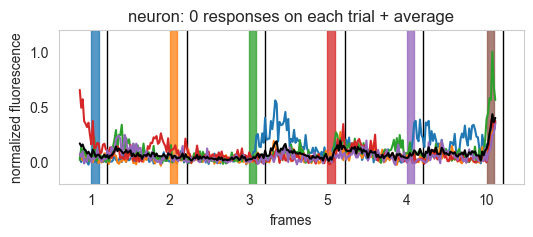

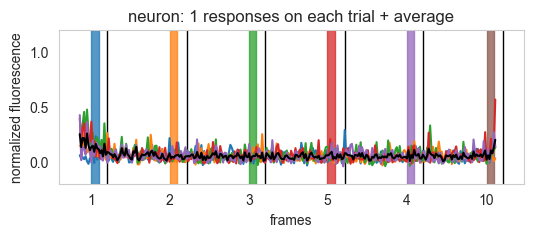

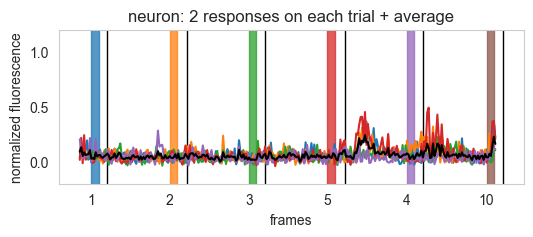

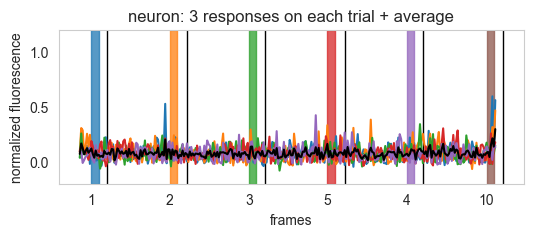

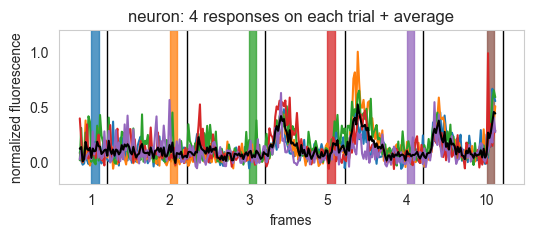

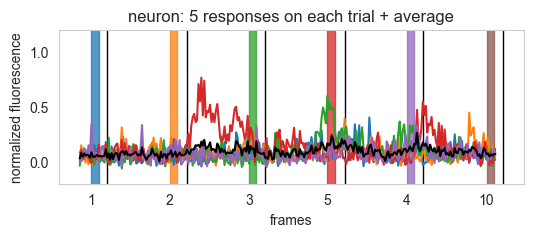

In [16]:
stacks_range = pd.DataFrame((zip(np.arange(0,len(stacked_resp),num_trials), np.arange(num_trials,len(stacked_resp)+num_trials,num_trials))), columns=['first','last'])
stim_names = list(color_dict.keys())
resp_per_trial_path = datapath + "\\" + "graphs" + "\\" + "resp_per_trial_minus_1st_trial"

if not os.path.exists(resp_per_trial_path):
    os.makedirs(resp_per_trial_path)

for neuron, trial in stacks_range[0:6].iterrows():
    plt.figure(figsize=(6,2))
    plt.title(f'neuron: {neuron} responses on each trial + average')
    plt.xlabel('frames')
    plt.ylabel('normalized fluorescence')
    plt.xticks(ticks=static_frames[0:len(color_dict)].tolist(), labels=stim_names)
    plt.ylim(-0.2,1.2)
    plt.grid(False)

    data = stacked_resp.iloc[trial['first']:trial['last']]
    for trace in range(len(data)):
        plt.plot(data.iloc[trace])
    plt.plot(np.mean(data),color='black')
    for frame, stimmy in zip(static_frames[0:len(color_dict)].tolist(), stim_names):
        if stimmy in color_dict.keys():
            plt.axvspan(frame + 5 , frame , color=color_dict[stimmy])

    for mframe, mstimmy in zip(motion_frames[0:len(color_dict)].tolist(), stim_names):
        if mstimmy in color_dict.keys():
            plt.axvspan(mframe, mframe , color='black')


    #plt.savefig(datapath + '\\' + 'graphs' + '\\' + 'resp_per_trial' + '\\' + f'neuron{neuron}.pdf')

In [330]:
#since these neuron's activity does not follow a normal distribution (becauswe it is skewed to the right/positive skew-tail), we will calculate outlier data points using statistical method called the interquartile range (IQR) instead of using z-score. Using the IQR, the outlier data points are the ones falling bellow Q1-1.5 IQR or above Q3 + 1.5 IQR. The Q1 is the 25th percentile  and Q3 is the 75th percentile of the dataset, and IQR represent the interquarile range cfalculatede by Q3 minus Q1 (Q3-Q1).

#Create a function to find outliers using IQR
def find_outliers_IQR(df, kind='stats'):

    '''
    If the value is not an outlier, it will display as NaN (not a number):
    :param df:
    :param full_view:
    :return:
    '''
    df = df.T
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1

    outliers= df[((df<q1-1.5*IQR)) | (df>(q3+1.5*IQR))]

    outliers_stats = pd.DataFrame()

    outliers_stats['max'] = outliers.max()
    outliers_stats['idx_max'] = outliers.idxmax()
    outliers_stats['min'] = outliers.min()
    outliers_stats['idx_min'] = outliers.idxmin()

    total_num_outliers = outliers.count()

    if kind=='full':
        return pd.DataFrame(outliers), outliers_stats
    if kind=='stats':
        return outliers_stats
    if kind=='outliers':
        return pd.DataFrame(outliers)

#### Choosing consistent neuron. Filter neurons using slope between sframe and mframe to determine if there is a peak. Those traces having

#### using SEM as error estimate

In [ ]:
#SEM is standard deviation and dividing it by the square root of the sample size.
#As size of sample data grows larger, the SEM decreases vs the SD. That is because as the sample size increases the sample mean estimate reflects the true mean of the population, so greater precision.
#INcreasing the sample size doesn't necessarily make the SD larger or smaller; it just becomes a more accurate estimate of the population standard deviation.
data = stacked_resp
stim_names = list(color_dict.keys())
fig, ax = plt.subplots(figsize=(10,6))

def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    SEM = scipy.stats.sem(data,axis=0)
    cis = (est - SEM, est + SEM)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

tsplot(ax, data)
#plt.ylim(0.04,0.06)
plt.xlabel("circle size")
plt.ylabel("normalized fluorescence")
dataset_name = datapath.split('\\')[-2:]
plt.title(f"Average response of OT neurons per size | {dataset_name}", pad=20)
plt.xticks(ticks=static_frames[0:len(color_dict)].tolist(), labels=stim_names)

for frame, stimmy in zip(static_frames[0:len(color_dict)].tolist(), stim_names):
    if stimmy in color_dict.keys():
        plt.axvspan(frame, frame , color=color_dict[stimmy])
'''
for frame, stimmy in zip(motion_frames[0:len(color_dict)].tolist(), stim_names):
    if stimmy in color_dict.keys():
        plt.axvspan(frame, frame , color='black')
'''
legend_lines = [Line2D([0], [0], color=clr) for clr in color_dict.values()]
legend_labels = [str(label) for label in color_dict.keys()]

plt.legend(legend_lines, legend_labels, title="radius", loc='center right', bbox_to_anchor=(1.2,0.5))

plt.show()

Smoothing the signal based on moving average box

#example of one neuron
yhat = savgol_filter(norm_stacked_avg.iloc[0],20,2)
plt.figure(figsize=(8,6))
plt.plot(norm_stacked_avg.iloc[0])
plt.plot(yhat, color='red')

for frame, stimmy in zip(dory.stimulus_df_condensed['static_frame'][0:6].tolist(), stim_names):
    if stimmy in color_dict.keys():
        plt.axvspan(frame, frame + 45, color=color_dict[stimmy])

for frame, stimmy in zip(dory.stimulus_df_condensed['motion_frame'][0:6].tolist(), stim_names):
    if stimmy in color_dict.keys():
        plt.axvspan(frame, frame , color='black')

plt.show()

In [36]:
stacks_range = pd.DataFrame((zip(np.arange(0,len(stacked_resp),num_trials), np.arange(num_trials,len(stacked_resp)+num_trials,num_trials))), columns=['first_trial','last_trial'])

baseline_length = 4 #how many frame before the start of the stimulus to average for the baseline activity

num_stims = len(np.unique(list(color_dict.keys())))
static_frames_head = list(dory.stimulus_df_condensed['static_frame'][0:num_stims])
motion_frames_head = list(dory.stimulus_df_condensed['motion_frame'][0:num_stims])
static_motionOn_frames = pd.DataFrame(zip(static_frames_head, motion_frames_head), columns=['static_frame', 'motion_frame'])

list_OutlierFiltered_stacked_resp = dict()

for neuron, (first_trial, last_trial) in tqdm(stacks_range.iterrows(), total=stacks_range.shape[0]):

    list_chunk_positive_resp = []
    for index, (sframe,mframe) in static_motionOn_frames.iterrows():
        #finding outliers
        test_trial_chunks_no_outlier = pd.DataFrame()

        trial_chunk = stacked_resp.iloc[first_trial:last_trial,sframe-baseline_length:sframe+6]
        peak_info = trial_chunk.max(axis=1) #this part gives me three values.not index is max of 0-2
        peak_mean = peak_info.mean()
        peak_std = peak_info.std()

        for idx, peak in peak_info.items():
            if not peak > peak_mean + 1.1 * peak_std:
                test_trial_chunks_no_outlier[idx] = trial_chunk.loc[idx] #print('no outliers here', i)

        #I don't want to take the mean of traces that although not an outlier, they maybe flat. let's take the r_values and compare
        r_values_NonOutlierTrial = []
        for i, NonOutlierTrial in test_trial_chunks_no_outlier.items():
            peak_idx = NonOutlierTrial.loc[sframe:].idxmax()
            y = NonOutlierTrial.loc[:peak_idx + 1]
            #y = np.asarray(NonOutlierTrial)
            slope, intercept, r_value, p_value, std_err = linregress(x=np.arange(len(y)), y=y)
            if r_value >= 0.10 and slope >= 0.002 and p_value < 0.06:
                r_values_NonOutlierTrial.append(1)
            else:
                r_values_NonOutlierTrial.append(0)

        if sum(r_values_NonOutlierTrial) > 1:

            #Take the r_value from each trial in test_trial_chunks_no_outlier.
            test_trial_chunks_no_outlier = test_trial_chunks_no_outlier.mean(axis=1)
            peak_index = test_trial_chunks_no_outlier.loc[sframe:].idxmax() #frame index
            peak_response_avg = test_trial_chunks_no_outlier.loc[peak_index-5:peak_index+5].mean()
            baseline_avg = test_trial_chunks_no_outlier.loc[:sframe].mean()
            baseline_std = test_trial_chunks_no_outlier.loc[:sframe].std()

            if peak_response_avg > 1.8*baseline_std + baseline_avg:
                list_chunk_positive_resp.append(1)
            elif peak_response_avg < 1.8*baseline_std + baseline_avg:
                list_chunk_positive_resp.append(0)
            else:
                list_chunk_positive_resp.append(0)
        else:
            list_chunk_positive_resp.append(0)

    list_OutlierFiltered_stacked_resp[neuron] = list_chunk_positive_resp

df_OutlierFiltered_stacked_resp = pd.DataFrame.from_dict(list_OutlierFiltered_stacked_resp).T
df_OutlierFiltered_stacked_resp.columns = stim_names


100%|██████████| 471/471 [00:10<00:00, 43.63it/s]


In [476]:
#Convert each trial chunk into a binary classification where 0 means no response and 1 is responsive (significantly)
accepted_neurons_binaryClass = pd.DataFrame()
discarded_neurons_binaryClass = pd.DataFrame()
for idx, row in df_OutlierFiltered_stacked_resp.iterrows():
    if row.sum() != 0:
        accepted_neurons_binaryClass = pd.concat([accepted_neurons_binaryClass, row], axis=1)
    else:
        discarded_neurons_binaryClass = pd.concat([discarded_neurons_binaryClass, row], axis=1)
accepted_neurons_binaryClass = accepted_neurons_binaryClass.T
discarded_neurons_binaryClass = discarded_neurons_binaryClass.T

#Use the accepted_neurons_binaryClass to get the activity traces from the chosen "accepted neurons" list
responsive_neurons = pd.DataFrame()
nonresponsive_neurons = pd.DataFrame()
accepted_neurons_indexes = list(accepted_neurons_binaryClass.index)
for idx, row in norm_stacked_avg.iterrows():
    if idx in accepted_neurons_indexes:
        responsive_neurons = pd.concat([responsive_neurons, row], axis=1)
    else:
        nonresponsive_neurons = pd.concat([nonresponsive_neurons, row], axis=1)
responsive_neurons = responsive_neurons.T
nonresponsive_neurons = nonresponsive_neurons.T

#re-order the dataframe to reflect sizes in ascending order
stim_names_int = natsorted(list(map(int,stim_names)))
ordered_stim_names = list(map(str, stim_names_int))
accepted_neurons_binaryClass= accepted_neurons_binaryClass[ordered_stim_names]

accepted_neurons_binaryClass


In [477]:
#get the average peak values for each size
ordered_static_frames = [84,13,156,227,369,298] #do this manually. Because I changed the order in accepted_respones table, which I need to change to index in resp_nrns tbl
peakResp_all = []

for i in range(len(responsive_neurons)):
    avg_peakResps_per_nrn = []
    for size, frame in zip(ordered_stim_names,ordered_static_frames):
        if accepted_neurons_binaryClass.iloc[i][size] == 1:
            peak_index = responsive_neurons.iloc[i,frame:frame+45].idxmax()
            peak_avg = responsive_neurons.iloc[i,peak_index-5:peak_index+5].mean()
            avg_peakResps_per_nrn.append(peak_avg)

        else:
            avg_peakResps_per_nrn.append(0)

    peakResp_all.append(avg_peakResps_per_nrn)

peakResp_all = pd.DataFrame(peakResp_all, columns=ordered_stim_names)
highest_value = peakResp_all.max(axis=1)
peakResp_all = peakResp_all.divide(highest_value, axis=0)
peakResp_all

In [489]:
#plot data
p_rows = len(responsive_neurons)
p_cols = len(stim_names_int)
fig_rows_num = ceil(p_rows/4)
fig_cols_num = 4

fig, axs = plt.subplots(nrows=fig_rows_num, ncols=fig_cols_num,layout='constrained',figsize=(3.5 * 4, 3.5 * fig_rows_num))

x_vals = [int(e) for e in stim_names_int]

nrn = 0
for (index, row), ax in zip(peakResp_all.iterrows(), axs.flat):
    #ax.axis('equal')
    ax.set_ylim([0,1])
    ax.set_title(f'neuron {index}')
    ax.set_ylabel('normalized df/f')
    ax.set_xlabel('circle diameter (degrees)')
    ax.set_xlim(0,max([int(i) for i in stim_names_int]) + 1)
    ax.set_xticks(stim_names_int)
    ax.annotate(f"WMR = {WMR[nrn]:.1f}",xy=(WMR[nrn],0.5), xytext=(WMR[nrn]+1,0.8),arrowprops=dict(facecolor='red', shrink=0.05))
    ax.grid(False)
    ax.bar(x_vals, row.values)
    ax.axvline(x=WMR[nrn], color='red')

    nrn+=1

#fig.savefig(datapath + '\\' + 'graphs' + '\\' + 'wmr_bar_graphs_corr.pdf')

In [495]:
cum_sum_0 = pd.DataFrame()
cum_sum_1 = pd.DataFrame()
cum_sum_2 = pd.DataFrame()
cum_sum_3 = pd.DataFrame()
cum_sum_4 = pd.DataFrame()

for key, counts in counts_fishSchool.items():
    cum_sum = ((counts.cumsum() / counts.sum())*100)
    #fig, ax = plt.subplots(figsize=(8, 4))
    if int(key[-1]) == 0: #if the key fish1_0 as 0 as its last value, append it to cum_sum_0 and so on
        cum_sum_0[key] = cum_sum
    if int(key[-1]) == 1:
        cum_sum_1[key] = cum_sum
    if int(key[-1]) == 2:
        cum_sum_2[key] = cum_sum
    if int(key[-1]) == 3:
        cum_sum_3[key] = cum_sum
    if int(key[-1]) == 4:
        cum_sum_4[key] = cum_sum
    #ax.plot(cum_sum)
    #ax.set_title(f'WMR unfed vs fed')

<AxesSubplot: >

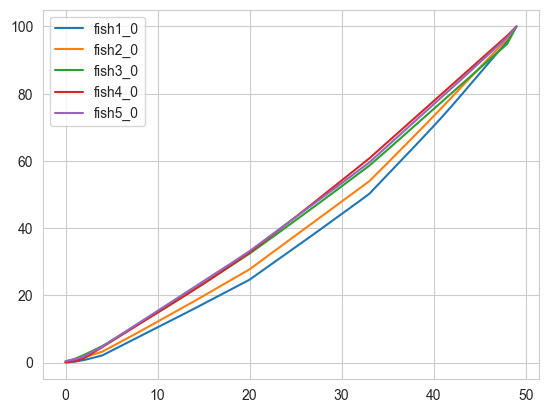

In [530]:
cum_sum_0.plot()
#plt.plot(data_fishSchool['fish1_4'],"r", data_fishSchool['fish2_4'], "b")

<AxesSubplot: >

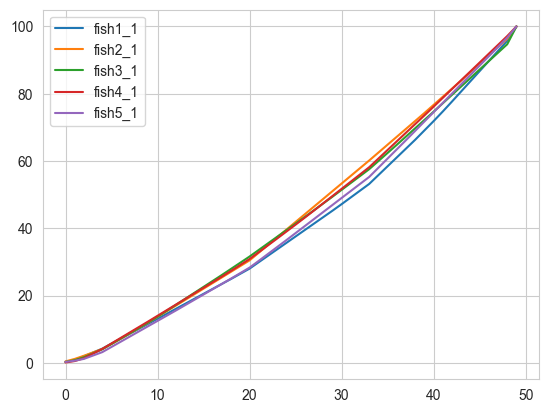

In [531]:
cum_sum_1.plot()

<AxesSubplot: >

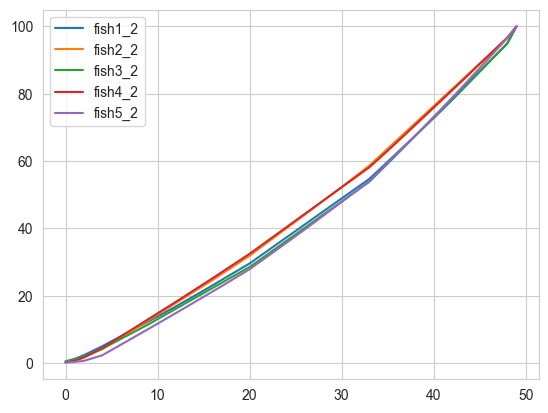

In [532]:
cum_sum_2.plot()

<AxesSubplot: >

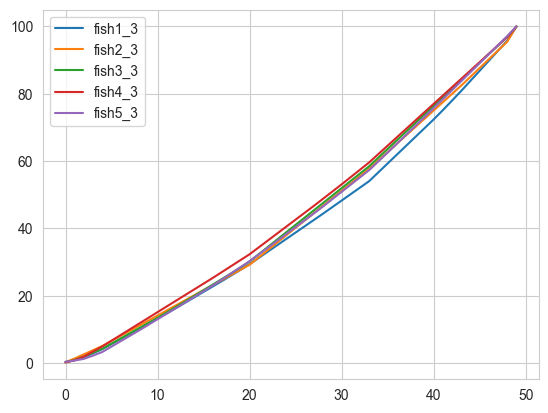

In [534]:
cum_sum_3.plot()

<AxesSubplot: >

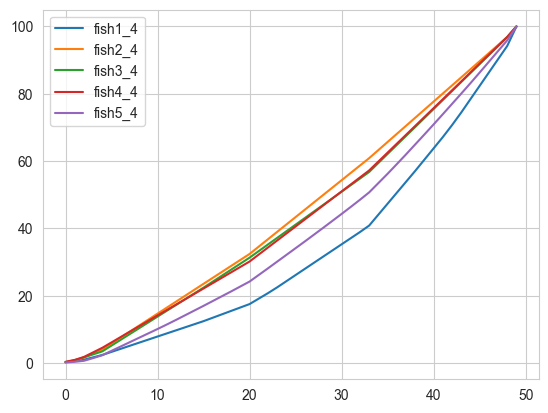

In [535]:
cum_sum_4.plot()

#colorful plots traces
for cell in responders_by_size.index:

    neuron = f_cells[cell]

    start_offset=10
    end_offset=20


    fig, ax = plt.subplots(6,1, figsize=(6, 12))

    for b in ax:
        b.set_xticks([])
        # b.set_yticks([])
        b.set_ylim(-0.25, 1.0)

    for n, stim in enumerate(color_dict.keys()):
        ax[n].set_title(f'radius : {stim}')

        stimmy = dory.stimulus_df_condensed[dory.stimulus_df_condensed.stim_name == stim]

        chunks = []
        for s in stimmy['original_frame']:
            chunk = neuron[s - start_offset : s + end_offset]
            ax[n].plot(chunk)
            chunks.append(chunk)

        ax[n].plot(np.mean(chunks, axis=0), color="black", linewidth=2.5)
        ax[n].axvspan(start_offset, start_offset , color="red", alpha=0.3)

    fig.tight_layout()
    plt.show()

cell = 0
fig, ax = plt.subplots(2,1, figsize=(18,6))

ax[0].plot(f_cells[cell])
ax[1].plot(f_cells[cell])

stimmystub = dory.stimulus_df_condensed[dory.stimulus_df_condensed.stim_name=='10']
for i in range(len(stimmystub)):
    s = stimmystub.iloc[i].static_frame
    ax[0].axvspan(s, s+10, color='red', alpha=0.3)
    ax[1].axvspan(s, s+10, color='red', alpha=0.3)

stimmystub = dory.stimulus_df_condensed[dory.stimulus_df_condensed.stim_name=='1']
for i in range(len(stimmystub)):
    s = stimmystub.iloc[i].static_frame
    ax[0].axvspan(s, s+10, color='purple', alpha=0.3)
    ax[1].axvspan(s, s+10, color='purple', alpha=0.3)

#ax[0].set_xlim(0,2500)
ax[1].set_xlim(500,1000)

used_colors = ['red', 'purple']
used_labels = ['10', '1']
legend_lines = [Line2D([0], [0], color=clr) for clr in used_colors]
legend_labels = [str(label) for label in used_labels]

fig.legend(legend_lines, legend_labels, title="radius", loc=7)
plt.show()

for i in range(len(stimmystub)):
    s = stimmystub.iloc[i].static_frame #.values[0] #What is wrong with this lines and what is it trying to do?
    print(s)

    plt.axvspan(s, s+10, color='red', alpha=0.5)

stimmystub

def window_stdev(X, window_size):
    '''The window size of a moving average filter refers to the number of data points that are used for the averaging process.
    The larger the window size, the more data points are used for the averaging process and the more smoothing is applied to the signal. A smaller window size will have a less smoothing effect on the signal, but may also reduce the accuracy of the filter.'''
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)
x = stacked_avg.iloc[0]
x = x*np.sqrt(9./8)
res = window_stdev(x,14)
plt.plot(res)

#Not sure what to make of this

#Define baseline_times over which you want to compute the baseline for each stimulus
baseline_len = 7 #frames before frame_start
n_cols = baseline_len * num_stim_reps
number_of_neurons = len(norm_stacked_avg)
responsive_neurons = []
responsive_neurons_stim = []

#for each neuron, evaluate the peak response in each stimulus group
for i in range(number_of_neurons):
    for value in dory.stimulus_df_condensed['static_frame'][0:6]:
        baseline_avg = np.average(norm_stacked_avg.iloc[i,value-frame_start[0]:value])  #take the average of baseline activity for a single neuron one stim at a time
        baseline_std = np.std(norm_stacked_avg.iloc[i,value-frame_start[0]:value])#single value
        peak_response = np.amax(norm_stacked_avg.iloc[i,value:value+45])#peak response for each neuron and stimulus

        #determine if the neuron i is responsive to a stimulus and if True, add the baseline activity and response to responsive_neurons
        #determine first whether based on the mean there is a significant high peak (sometimes outliers get lost in the mean)
        if peak_response > 1.8*baseline_std + baseline_avg:
            responsive_neurons.append(i)
            responsive_neurons_stim.append(value)


after_filtering = len(np.unique(responsive_neurons))
original_num = len(norm_stacked_avg)
diff = original_num - after_filtering
if len(np.unique(responsive_neurons)) == len(norm_stacked_avg):
    print('original number of neurons is the same after filtering')
if len(np.unique(responsive_neurons)) < len(norm_stacked_avg):
    print(f'after filtering, {diff} neurons were dropped')

filtered_neurons = pd.DataFrame(list(zip(responsive_neurons,responsive_neurons_stim)), columns=['neuron_num','stim_frame'])
filtered_neurons

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

fig2 = px.box(stacked_resp.iloc[0:5])
fig2.show()

fig2 = px.box(stacked_resp.iloc[0:5].T)
fig2.show()

fig3 = px.histogram(stacked_resp.iloc[0:5])
fig3.show()

stacked_resp.iloc[0:5].describe()